In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import seaborn as sns
from collections import Counter

In [3]:
path = Path('/data/yelp/')
assert path.exists()

In [4]:
!ls {path}

balanced_simplified_reviews.pkl      yelp_academic_dataset_tip.json
best_model			     yelp_academic_dataset_user.json
Dataset_User_Agreement.pdf	     yelp_reviews_simple_1000000.json
simple_output			     yelp_reviews_simple_2000000.json
yelp_academic_dataset_business.json  yelp_reviews_simple_200000.json
yelp_academic_dataset_checkin.json   yelp_reviews_simple_400000.json
yelp_academic_dataset_review.json    yelp_reviews_simple.json


In [5]:
!wc -l {path}/yelp_academic_dataset_review.json

8021122 /data/yelp/yelp_academic_dataset_review.json


In [7]:
review_file = path/'yelp_academic_dataset_review.json'

In [8]:
%%time

sample_size = 8_021_122
simplified_reviews = path/f'yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

Processed 100000
Processed 200000
Processed 300000
Processed 400000
Processed 500000
Processed 600000
Processed 700000
Processed 800000
Processed 900000
Processed 1000000
Processed 1100000
Processed 1200000
Processed 1300000
Processed 1400000
Processed 1500000
Processed 1600000
Processed 1700000
Processed 1800000
Processed 1900000
Processed 2000000
Processed 2100000
Processed 2200000
Processed 2300000
Processed 2400000
Processed 2500000
Processed 2600000
Processed 2700000
Processed 2800000
Processed 2900000
Processed 3000000
Processed 3100000
Processed 3200000
Processed 3300000
Processed 3400000
Processed 3500000
Processed 3600000
Processed 3700000
Processed 3800000
Processed 3900000
Processed 4000000
Processed 4100000
Processed 4200000
Processed 4300000
Processed 4400000
Processed 4500000
Processed 4600000
Processed 4700000
Processed 4800000
Processed 4900000
Processed 5000000
Processed 5100000
Processed 5200000
Processed 5300000
Processed 5400000
Processed 5500000
Processed 5600000
P

In [9]:
!wc -l {simplified_reviews}

8021121 /data/yelp/yelp_reviews_simple_8021122.json


In [10]:
!head {simplified_reviews}

{"text": "I am actually horrified this place is still in business. My 3 year old son needed a haircut this past summer and the lure of the $7 kids cut signs got me in the door. We had to wait a few minutes as both stylists were working on people. The decor in this place is total garbage. It is so tacky. The sofa they had at the time was a pleather sofa with giant holes in it. And my son noticed ants crawling all over the floor and the furniture. It was disgusting and I should have walked out then. Actually, I should have turned around and walked out upon entering but I didn't. So the older black male stylist finishes the haircut he was doing and it's our turn. I tell him I want a #2 clipper around the back and sides and then hand cut the top into a standard boys cut. Really freaking simple, right? WRONG! Rather than use the clippers and go up to actually cut the hair, he went down. Using it moving downward doesn't cut hair, it just rubs against it. How does this man who has an alleged 

In [11]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)

In [12]:
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021121 entries, 0 to 8021120
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   stars   int64 
dtypes: int64(1), object(1)
memory usage: 122.4+ MB


In [13]:
simplified_reviews_pd

,text,stars
0,I am actually horrified this place is still in...,1
1,I love Deagan's. I do. I really do. The atmosp...,5
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
3,"Oh happy day, finally have a Canes near my cas...",4
4,This is definitely my favorite fast food sub s...,5
...,...,...
8021116,"Fricken unbelievable, I ordered 2 space heater...",1
8021117,Solid American food with a southern comfort fl...,3
8021118,I'm honestly not sure how I have never been to...,5
8021119,Food was decent but I will say the service too...,3


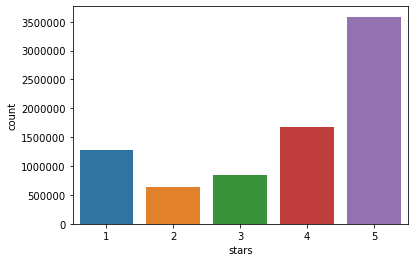

In [14]:
sns.countplot(simplified_reviews_pd['stars'])

### Create a balanced dataset
In the following cells we try to create a balanced dataset with the same amount of records in each category.

In [15]:
counter_star = Counter(simplified_reviews_pd['stars'])

In [16]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 635071)

In [17]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 648826, 5: 2951389, 4: 1038333, 3: 207218, 2: 0}

In [18]:
remove_amounts[1] -= 1
remove_amounts

{1: 648825, 5: 2951389, 4: 1038333, 3: 207218, 2: 0}

Gathering all indices that are going to be deleted.

In [19]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 8min 6s, sys: 47.6 ms, total: 8min 6s
Wall time: 8min 6s


4845765

In [20]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

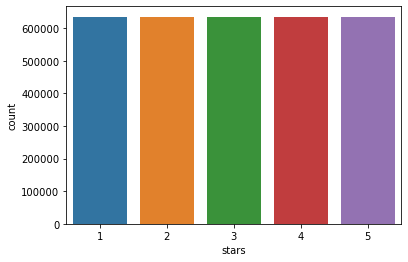

In [21]:
sns.countplot(balanced_simplified_reviews['stars'])

In [22]:
balanced_simplified_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3175356 entries, 31 to 8021120
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   stars   int64 
dtypes: int64(1), object(1)
memory usage: 72.7+ MB


In [23]:
balanced_simplified_reviews.to_pickle(path/'balanced_simplified_reviews_full.pkl')

In [27]:
!du -h {path}/'balanced_simplified_reviews_full.pkl'

2.1G	/data/yelp/balanced_simplified_reviews_full.pkl
